In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import log_loss
sns.set()
sns.set_style('whitegrid')

from scipy import stats

import statsmodels.api as sm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from scipy.stats import randint as sp_randint


In [2]:
df = pd.read_csv('Trial_99_Cleaned')

In [3]:
rating = {'Excellent': 'High',
          'Good':'High',
          'No effect': 'Low',
          'Not good':'Low',
          'Awful': "Low"}
df['Overall_Exp_Rating'] = df['Overall_Experience'].map(rating)

In [4]:
df['Overall_Exp_Rating']=df['Overall_Exp_Rating'].map({'High': 1, 'Low':0})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 23 columns):
Start_Date                         102 non-null object
End_Date                           102 non-null object
Last_Name                          102 non-null object
Version_Duration                   102 non-null object
Sleep_Quality                      100 non-null object
Overall_Experience                 102 non-null object
Focus_Atten_Concen                 101 non-null object
Memory                             101 non-null object
Drive_Passion_Motivation           101 non-null object
Physical_Energy                    101 non-null object
Capacity_Productivity              101 non-null object
Decisiveness                       101 non-null object
Verbal_Fluency_Word_Recall         100 non-null object
Creativity_Insight                 101 non-null object
InterpersonalCapability_Empathy    100 non-null object
Emotional_Stability                101 non-null object
Euphoria_Joy_Ha

## Logloss: measures the performance of a classification model
input = is the probability value between 0 and 1. You want to minimize the logloss as much as possible. A perfect model would have a logloss value of zero. 

Used as a evaluation metric. 

Logloss quantifies accuracy of a classifier by penalizing false classification. Minimizing logloss is basically maximizing accuracy of the classifier. 

In [6]:
df['Sleep_Quality'] = df['Sleep_Quality'].astype('category')
df['Sleep_Quality'] = df['Sleep_Quality'].cat.reorder_categories(['Poor', 'OK','Excellent'], ordered=True)
df['Sleep_Quality'] = df['Sleep_Quality'].cat.codes

In [7]:
feat =  [ 6,  7,  8,  9, 10, 11, 12, 14, 15, 16] #creativity insight only has two responses, so we have to skip it

In [8]:
for col in df[feat]:
    df[col] = df[col].astype('category')
    df[col]= df[col].cat.reorder_categories(['Less good', 'No effect', 'Improved'], ordered=True)
    df[col] = df[col].cat.codes

In [9]:
df['Creativity_Insight'].value_counts()

Improved     51
No effect    50
Name: Creativity_Insight, dtype: int64

In [10]:
df['Creativity_Insight'] = df['Creativity_Insight'].astype('category')
df['Creativity_Insight'] = df['Creativity_Insight'].cat.reorder_categories(['No effect', 'Improved'], ordered=True)
df['Creativity_Insight'] = df['Creativity_Insight'].cat.codes

In [11]:
df['Estimated_Effect_Duration'] = df['Estimated_Effect_Duration'].astype('category')
df['Estimated_Effect_Duration'] = df['Estimated_Effect_Duration'].cat.reorder_categories(['<2', '2-4', '4-8','8+'], ordered=True)
df['Estimated_Effect_Duration'] = df['Estimated_Effect_Duration'].cat.codes

In [12]:
df['Overall_Experience'] = df['Overall_Experience'].astype('category')
df['Overall_Experience'] = df['Overall_Experience'].cat.reorder_categories(['Awful','Not good','No effect','Good', 'Excellent'], ordered=True)
df['Overall_Experience'] = df['Overall_Experience'].cat.codes

In [13]:
df['User_Status'] = df['User_Status'].astype('category')
df['User_Status'] = df['User_Status'].cat.reorder_categories(['Non-user', 'XNootropic User'], ordered=True)
df['User_Status'] = df['User_Status'].cat.codes

In [14]:
features = [  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 21]

In [15]:
df[features].head()

,Sleep_Quality,Focus_Atten_Concen,Memory,Drive_Passion_Motivation,Physical_Energy,Capacity_Productivity,Decisiveness,Verbal_Fluency_Word_Recall,Creativity_Insight,InterpersonalCapability_Empathy,Emotional_Stability,Euphoria_Joy_Happiness,Estimated_Effect_Duration,User_Status
0,1,2,2,2,2,2,2,1,0,1,1,1,2,0
1,1,2,1,1,2,2,1,1,0,1,2,2,2,0
2,1,2,2,0,0,0,2,2,1,2,1,1,3,1
3,1,2,2,2,2,2,2,2,1,1,1,1,3,1
4,1,2,1,2,2,2,1,1,0,1,1,2,2,1


## Data is transformed into arrays

In [32]:
f = [4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22]
array = df[f].values
X = array[:, 0:14]
y = array[:, 14]

In [75]:
data = df[f] # trying to see if we can keep column names
y = data.Overall_Exp_Rating
X = data.drop(['Overall_Exp_Rating'], axis=1)

## Comparing Models with KFold Crossvalidation without feature selection

Comparing between the two models, it seems that SVM and RandomForest are the models that have the highest accuracy scores between the four models. However, this is done without feature selection and hyperparameter tuning. 

In [77]:
#svm
SVM = SVC()
scores = cross_val_score(SVM, X,y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[ 0.90909091  0.90909091  0.9         0.9         1.          1.          1.
  1.          0.9         1.        ]
0.951818181818


In [85]:
SVM = SVC(kernel='linear')
scores = cross_val_score(SVM, X,y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[ 1.          0.81818182  0.7         0.9         1.          1.          1.
  1.          0.9         0.9       ]
0.921818181818


In [470]:
#logistic regression
logit = LogisticRegression()
scores = cross_val_score(logit, X,y, cv=10, scoring='accuracy')
print (scores.mean())

0.940909090909


In [79]:
#randomforest
rf = RandomForestClassifier()
scores = cross_val_score(rf, X,y, cv=10, scoring='accuracy')
print (scores.mean())

0.96


In [80]:
#extra trees
et = ExtraTreesClassifier()
scores = cross_val_score(et,X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.930909090909


## Feature Selection with KFold

In [304]:
def plot_nfeat(model):
    selector = RFECV(model, step=1, cv=StratifiedKFold(10))
    selector.fit(X,y)
    print ('Optimal Number of Features: {}'.format(selector.n_features_))
    plt.figure()
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Cross Validation Score')
    plt.plot(range(1,len(selector.grid_scores_)+1), selector.grid_scores_)

Optimal Number of Features: 3


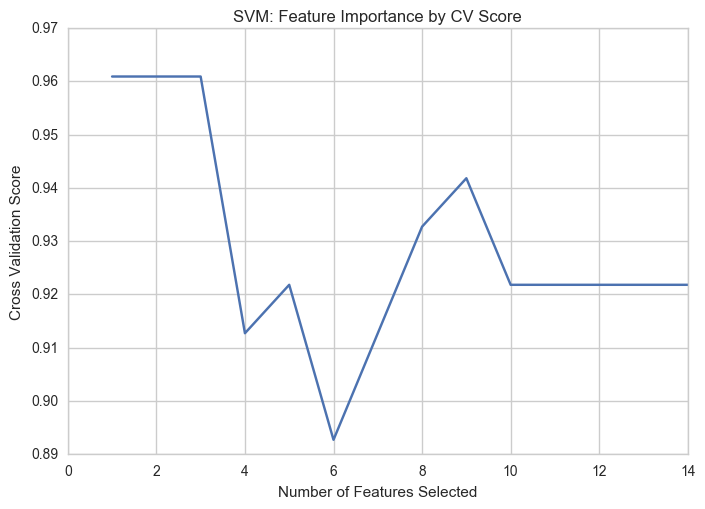

In [305]:
plot_nfeat(SVM)
plt.title('SVM: Feature Importance by CV Score')

Optimal Number of Features: 1


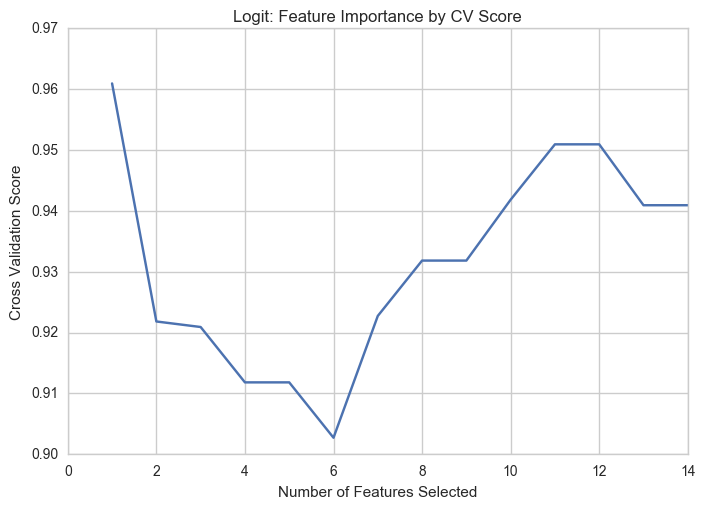

In [307]:
#logit
plot_nfeat(logit)
plt.title('Logit: Feature Importance by CV Score')

Optimal Number of Features: 12


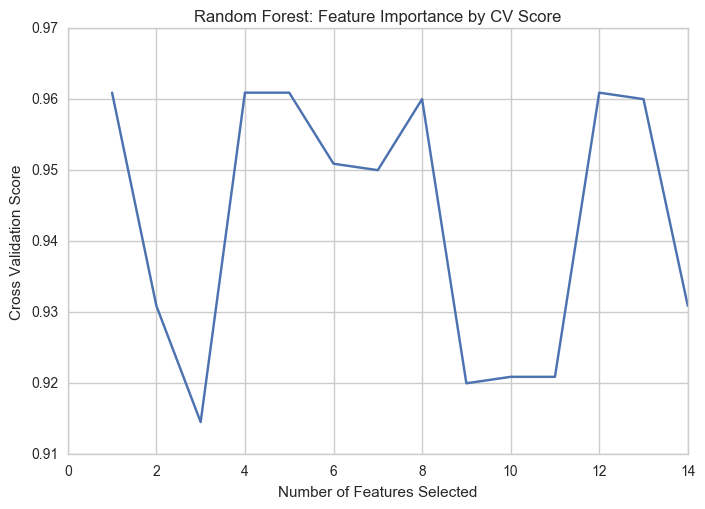

In [308]:
plot_nfeat(rf)
plt.title('Random Forest: Feature Importance by CV Score')

Optimal Number of Features: 10


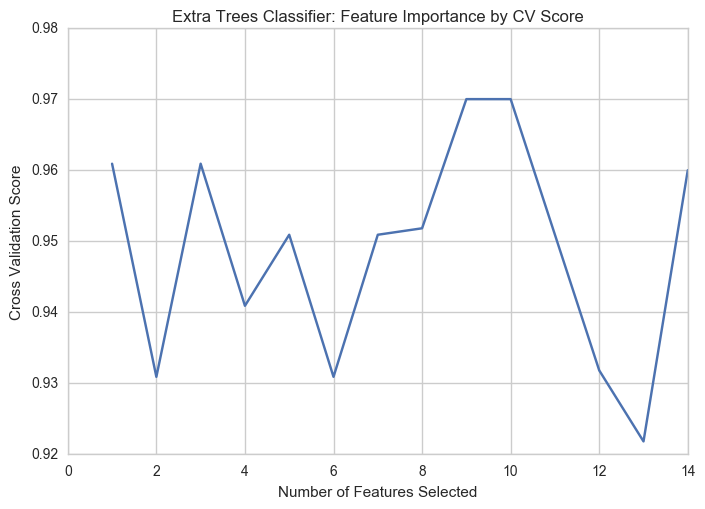

In [310]:
#extratrees
plot_nfeat(et)
plt.title('Extra Trees Classifier: Feature Importance by CV Score')

In [441]:
def getting_topfeats(model, n_feat):
    """uses Kfold and RFE feature selection"""
    top_feats = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):
    #print ("Train:", train_index, "Test:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_ = model
        rfe_model = RFE(model_, n_feat, step=1)
        rfe_model = rfe_model.fit(X_train,y_train)
        headers= ['Name', 'Ranking']
        values = sorted(zip(X_train.columns, rfe_model.ranking_))
        top_feat = filter(lambda x: x[:][1] == 1, values)
        top_feats.append(top_feat)
    
    unique_feats = np.unique((np.array(top_feats)))
    top_features = unique_feats.tolist()
    return top_features[1:]

In [445]:
getting_topfeats(SVM, 3)

['Emotional_Stability',
 'Euphoria_Joy_Happiness',
 'InterpersonalCapability_Empathy',
 'Memory',
 'Physical_Energy',
 'User_Status',
 'Verbal_Fluency_Word_Recall']

In [449]:
getting_topfeats(logit,1)

['Physical_Energy']

In [450]:
getting_topfeats(rf,12 )

['Capacity_Productivity',
 'Creativity_Insight',
 'Decisiveness',
 'Drive_Passion_Motivation',
 'Emotional_Stability',
 'Estimated_Effect_Duration',
 'Euphoria_Joy_Happiness',
 'Focus_Atten_Concen',
 'InterpersonalCapability_Empathy',
 'Memory',
 'Physical_Energy',
 'Sleep_Quality',
 'User_Status',
 'Verbal_Fluency_Word_Recall']

In [530]:
data = df[f] 
y = data.Overall_Exp_Rating
X = data.drop(['Overall_Exp_Rating'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

                                    Score
Name                                     
Physical_Energy                  0.225411
Estimated_Effect_Duration        0.144085
Sleep_Quality                    0.114567
Drive_Passion_Motivation         0.102543
Euphoria_Joy_Happiness           0.098657
Decisiveness                     0.088291
Focus_Atten_Concen               0.078374
Capacity_Productivity            0.051526
Emotional_Stability              0.036456
Verbal_Fluency_Word_Recall       0.020439
Memory                           0.014463
Creativity_Insight               0.014263
InterpersonalCapability_Empathy  0.010923
User_Status                      0.000000


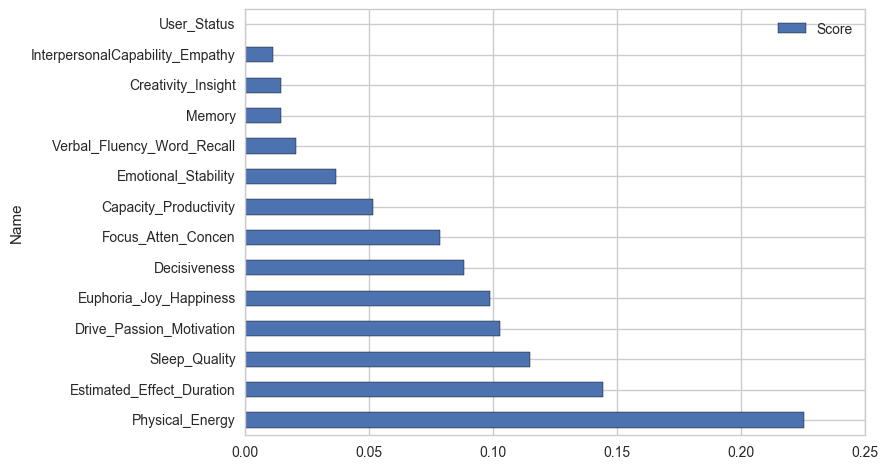

In [531]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test,y_test)
headers= ['Name', 'Score']
values = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x:x[1]* -1)
df_2 = pd.DataFrame(data=values, columns=headers).set_index('Name')
print (df_2)
df_2.plot(kind='barh')

In [451]:
getting_topfeats(et, 10)

['Capacity_Productivity',
 'Creativity_Insight',
 'Decisiveness',
 'Drive_Passion_Motivation',
 'Emotional_Stability',
 'Estimated_Effect_Duration',
 'Euphoria_Joy_Happiness',
 'Focus_Atten_Concen',
 'Physical_Energy',
 'Sleep_Quality',
 'User_Status',
 'Verbal_Fluency_Word_Recall']

                                    Score
Name                                     
Physical_Energy                  0.303843
Drive_Passion_Motivation         0.108983
Focus_Atten_Concen               0.094918
Decisiveness                     0.082371
Estimated_Effect_Duration        0.077585
Euphoria_Joy_Happiness           0.075917
Sleep_Quality                    0.064877
Emotional_Stability              0.062226
Capacity_Productivity            0.042347
Verbal_Fluency_Word_Recall       0.034250
Creativity_Insight               0.032537
User_Status                      0.009125
InterpersonalCapability_Empathy  0.007044
Memory                           0.003978


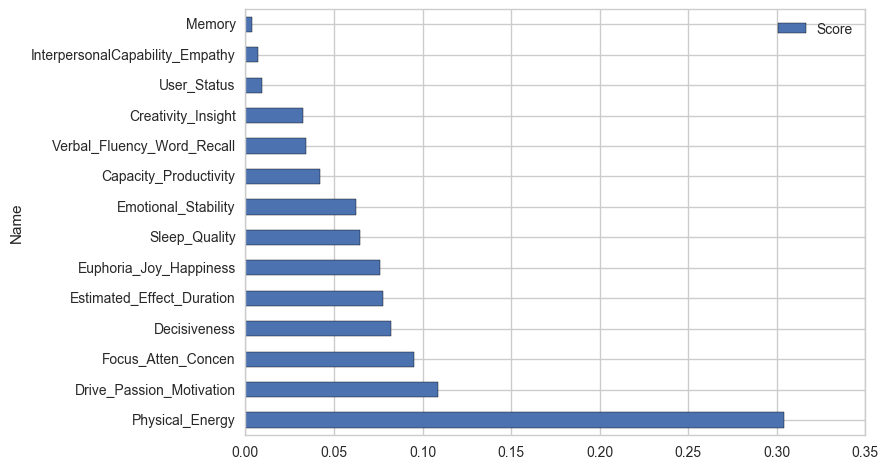

In [532]:
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
headers= ['Name', 'Score']
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x:x[1]* -1)
df_2 = pd.DataFrame(data=values, columns=headers).set_index('Name')
print (df_2)
df_2.plot(kind='barh')

# Parameter Tuning with GridSearchCV

In [464]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

## SVM

In [405]:

Cs = [0.001, 0.01, 0.1, 1, 10]
g = np.logspace(-1,0,10)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': g,
                     'C': Cs},
                    {'kernel': ['linear'], 'C': Cs}]

Testing Accuracy Score: 0.957746478873
Best Parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 0.10000000000000001}
Test Accuracy Score Test: 0.935483870968
Sanity Check: 0.935483870968
	
             precision    recall  f1-score   support

          0       0.50      0.50      0.50         2
          1       0.97      0.97      0.97        29

avg / total       0.94      0.94      0.94        31



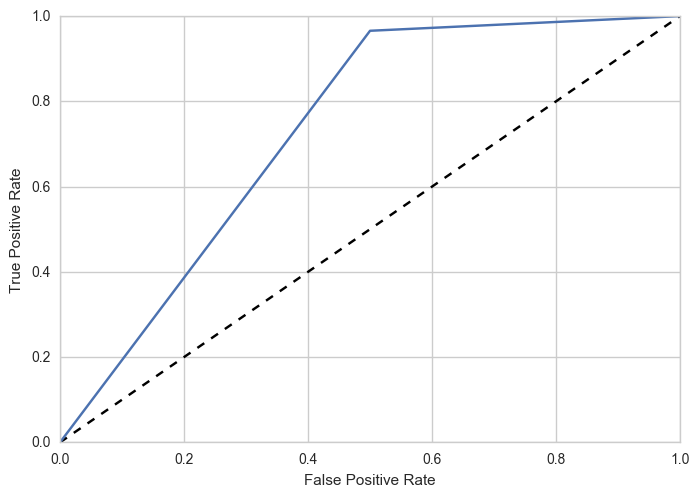

In [492]:
model_cv = GridSearchCV(SVC(), tuned_parameters,cv=10)
model_cv.fit(X_train,y_train)
print ('Testing Accuracy Score: {}'.format(model_cv.best_score_))
print ('Best Parameters: {}'.format(model_cv.best_params_))
print('Test Accuracy Score Test: {}'.format(model_cv.score(X_test,y_test)))
score = SVC(C=model_cv.best_estimator_.C, gamma=model_cv.best_estimator_.gamma,
             kernel=model_cv.best_estimator_.kernel).fit(X_train, y_train).score(X_test, y_test)
print('Sanity Check: {}'.format(score))
y_pred = model_cv.predict(X_test)
print("\t")
print (classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [434]:
#important features only

In [446]:
X_f = df[['Emotional_Stability',
 'Euphoria_Joy_Happiness',
 'InterpersonalCapability_Empathy',
 'Memory',
 'Physical_Energy',
 'User_Status',
 'Verbal_Fluency_Word_Recall']]
y_f = df['Overall_Exp_Rating']

In [458]:
X_train, X_test, y_train, y_test = train_test_split(
    X_f, y_f, test_size=0.3, random_state=0)

Testing Accuracy Score: 0.957746478873
Best Parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 0.10000000000000001}
Test Accuracy Score Test: 0.935483870968
Sanity Check: 0.935483870968
	
             precision    recall  f1-score   support

          0       0.50      0.50      0.50         2
          1       0.97      0.97      0.97        29

avg / total       0.94      0.94      0.94        31



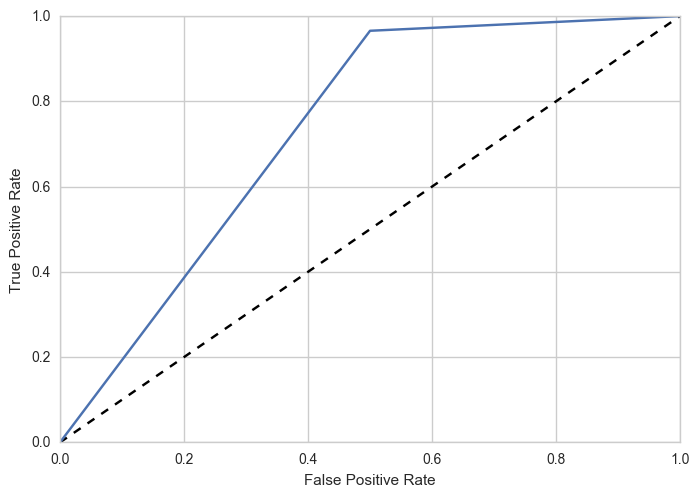

In [491]:
model_cv = GridSearchCV(SVC(), tuned_parameters,cv=10)
model_cv.fit(X_train,y_train)
print ('Testing Accuracy Score: {}'.format(model_cv.best_score_))
print ('Best Parameters: {}'.format(model_cv.best_params_))
print('Test Accuracy Score Test: {}'.format(model_cv.score(X_test,y_test)))
score = SVC(C=model_cv.best_estimator_.C, gamma=model_cv.best_estimator_.gamma,
             kernel=model_cv.best_estimator_.kernel).fit(X_train, y_train).score(X_test, y_test)
print('Sanity Check: {}'.format(score))
y_pred = model_cv.predict(X_test)
print("\t")
print (classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Logistic Regression

In [503]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [506]:
params = {'C': [0.001,0.01, 0.1, 1, 10, 100]}

Testing Accuracy Score: 0.901408450704
Best Parameters: {'C': 1}
Test Accuracy Score Test: 1.0
Sanity Check: 1.0
	
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00        29

avg / total       1.00      1.00      1.00        31



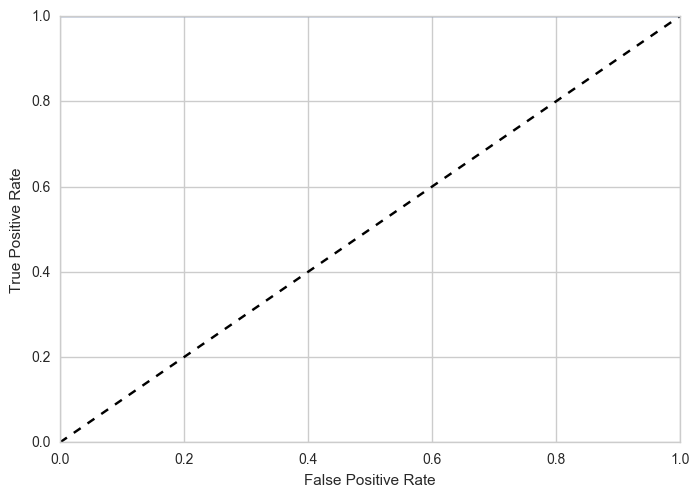

In [508]:
model_cv = GridSearchCV(LogisticRegression(),params ,cv=10)
model_cv.fit(X_train,y_train)
print ('Testing Accuracy Score: {}'.format(model_cv.best_score_))
print ('Best Parameters: {}'.format(model_cv.best_params_))
print('Test Accuracy Score Test: {}'.format(model_cv.score(X_test,y_test)))
score = LogisticRegression(C=model_cv.best_estimator_.C).fit(X_train, y_train).score(X_test, y_test)
print('Sanity Check: {}'.format(score))
y_pred = model_cv.predict(X_test)
print("\t")
print (classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [525]:
#important features 

X_logit = df['Physical_Energy']
y_logit = df['Overall_Exp_Rating']
xl = np.array(X_logit).reshape(-1,1)
yl = np.array(y_logit).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    xl, xl, test_size=0.3, random_state=0)

In [528]:
model_cv = GridSearchCV(LogisticRegression(),params ,cv=10)
model_cv.fit(X_train,y_train)
print ('Testing Accuracy Score: {}'.format(model_cv.best_score_))
print ('Best Parameters: {}'.format(model_cv.best_params_))
print('Test Accuracy Score Test: {}'.format(model_cv.score(X_test,y_test)))
score = LogisticRegression(C=model_cv.best_estimator_.C).fit(X_train, y_train).score(X_test, y_test)
print('Sanity Check: {}'.format(score))
y_pred = model_cv.predict(X_test)
print("\t")
print (classification_report(y_test, y_pred))


Testing Accuracy Score: 0.929577464789
Best Parameters: {'C': 100}
Test Accuracy Score Test: 0.935483870968
Sanity Check: 0.935483870968
	
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.75      1.00      0.86         6
          2       1.00      1.00      1.00        23

avg / total       0.89      0.94      0.91        31



## Random Forest

In [562]:
data = df[f] # trying to see if we can keep column names
y = data.Overall_Exp_Rating
X = data.drop(['Overall_Exp_Rating'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [542]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
n_iter_search = 20


In [589]:
model_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10)

model_cv.fit(X_train, y_train)
print ('Testing Accuracy Score: {}'.format(model_cv.best_score_))
print ('Best Parameters: {}'.format(model_cv.best_params_))
print('Test Accuracy Score Test: {}'.format(model_cv.score(X_test,y_test)))
score = RandomForestClassifier(bootstrap=model_cv.best_estimator_.bootstrap, min_samples_leaf=model_cv.best_estimator_.min_samples_leaf,
                             min_samples_split=model_cv.best_estimator_.min_samples_split, criterion=model_cv.best_estimator_.criterion,
                             max_features=model_cv.best_estimator_.max_features, max_depth=model_cv.best_estimator_.max_depth).fit(X_train, y_train).score(X_test, y_test)
print('Sanity Check: {}'.format(score))
y_pred = model_cv.predict(X_test)
print("\t")
print (classification_report(y_test, y_pred))

Testing Accuracy Score: 0.943661971831
Best Parameters: {'bootstrap': False, 'min_samples_leaf': 3, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 7, 'max_depth': 3}
Test Accuracy Score Test: 1.0
Sanity Check: 1.0
	
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00        29

avg / total       1.00      1.00      1.00        31

